In [17]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


In [18]:
data_dir = 'data'
crater_dir = os.path.join(data_dir, 'craters')
no_crater_dir = os.path.join(data_dir, 'no_craters')
test_data_dir = 'test_data'

In [19]:
image_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split data into 80% train, 20% validation
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Keep order for evaluation
)

Found 389 images belonging to 2 classes.
Found 97 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [20]:
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


In [21]:
model = build_model()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
from tensorflow.keras.callbacks import Callback 
class TestPerformanceCallback(Callback):
    def __init__(self, test_generator):
        super().__init__()
        self.test_generator = test_generator
        self.test_loss = []
        self.test_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        loss, accuracy = self.model.evaluate(self.test_generator, verbose=0)
        self.test_loss.append(loss)
        self.test_accuracy.append(accuracy)
        print(f"Epoch {epoch + 1}: Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

test_performance_callback = TestPerformanceCallback(test_generator)

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('crater_detection_model.keras', monitor='val_loss', save_best_only=True)


In [24]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # Start with a high number, and let early stopping cut off
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/50


C:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 324ms/step - accuracy: 0.4587 - loss: 1.0624 - val_accuracy: 0.4948 - val_loss: 0.6941
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.4966 - loss: 0.6932 - val_accuracy: 0.5052 - val_loss: 0.6863
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.4979 - loss: 0.6871 - val_accuracy: 0.5052 - val_loss: 0.6880
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 0.5528 - loss: 0.6748 - val_accuracy: 0.5052 - val_loss: 0.6866
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.4927 - loss: 0.6803 - val_accuracy: 0.5361 - val_loss: 0.6790
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.5208 - loss: 0.6567 - val_accuracy: 0.9278 - val_loss: 0.6536
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.6026 - loss: 0.6169 - val_accuracy: 0.5567 - val_loss: 0.6426
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - accuracy: 0.7737 - loss: 0.4898 - val_accuracy: 0.9278 - val_

In [25]:
model.load_weights('crater_detection_model.keras')
val_loss, val_accuracy = model.evaluate(validation_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.9533 - loss: 0.1890
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9786 - loss: 0.0745
Validation Accuracy: 0.9485
Test Accuracy: 0.9850


In [27]:
model.load_weights('crater_detection_model.keras')
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Final Test Accuracy: {test_accuracy:.4f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9786 - loss: 0.0745
Final Test Accuracy: 0.9850


In [28]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_image(image_path, model):
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img) / 255.0  # Rescale
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return 'No Craters'
    else:
        return 'Craters'


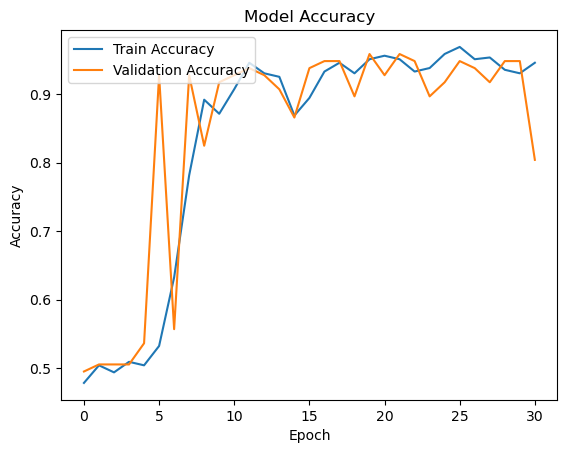

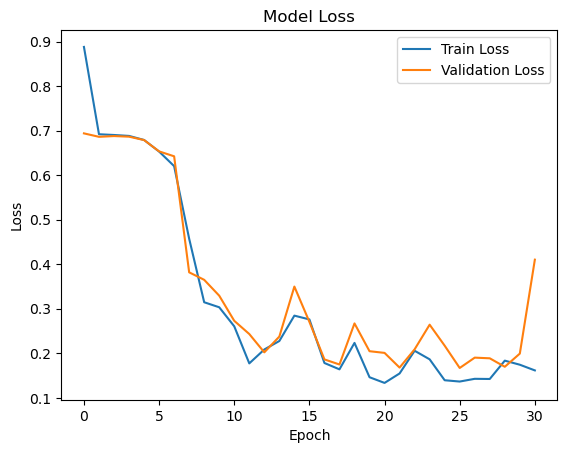

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



In [39]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def classify_image(image_path, model, image_size=(128, 128)):

    # Load and preprocess the image
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img_array)
    
    # Interpret the result
    if prediction[0][0] > 0.5:
        return 'No Craters'
    else:
        return 'Craters'

# Example usage
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('crater_detection_model.keras')

# Predict a sample image
image_path = 'crater1.jpg' # sample image with craters
result = classify_image(image_path, model)
print(f"The image is classified as: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
The image is classified as: Craters


In [42]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def classify_image(image_path, model, image_size=(128, 128)):

    # Load and preprocess the image
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img_array)
    
    # Interpret the result
    if prediction[0][0] > 0.5:
        return 'No Craters'
    else:
        return 'Craters'

# Example usage
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('crater_detection_model.keras')

# Predict a sample image
image_path = 'no_crater3.jpg' # sample image with no craters
result = classify_image(image_path, model)
print(f"The image is classified as: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
The image is classified as: No Craters
